<a href="https://colab.research.google.com/github/RiverGumSecurity/AILabs/blob/dev-derek/labs/Module02_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning and Neural Networks with Phishing Email Data

Neural networks are a subset of machine learning algorithms inspired by the human brain's structure and function. They consist of layers of interconnected "neurons" that transform the input data through weighted connections to produce an output. Neural networks are particularly powerful for complex tasks like image recognition and natural language processing.

Neural networks consist of an input layer, one or more hidden layers, and an output layer. These layers consist of "neurons" where each neuron processes input data by applying a weight and an activation function (like sigmoid or ReLU) to produce an output. The training (or learning) process adjusts the weights of the connections between neurons using algorithms like backpropagation and optimization techniques like gradient descent. Neural networks, particularly deep neural networks (deep learning), can model highly complex relationships between inputs and outputs by learning hierarchical feature representations in the hidden layers. Deep learning neural networks typically contain three or more hidden layers.

<center><img src="https://images.edrawsoft.com/articles/neural-network-diagram/example1.png" width="800" height="600"></center>




In [1]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import plotly.express as px
import datetime
import os 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
import warnings

2024-11-08 11:59:03.149221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 11:59:03.156540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 11:59:03.164656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 11:59:03.167274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 11:59:03.173605: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Supress debug warnings in training output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages
tf.get_logger().setLevel('ERROR')

In [3]:
# Set random seed static value for consistent results
seed = 42

In [4]:
# Detect GPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6226240972625269546
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9963569152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3703774812298003391
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1731085144.140256   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085144.163350   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085144.163393   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085144.288672   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085144.288735   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

## Dataset

The dataset that will be used to train and test the different models was from https://www.kaggle.com/datasets/subhajournal/phishingemails.  It was pre-labeled as "Safe Email" or "Phishing Email".  The data will be cleaned and prepared for training machine learning models with Pandas.

In [6]:
# Read in the data into a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/RiverGumSecurity/AILabs/main/datasets/Phishing_Email.csv')
#df = pd.read_csv('../datasets/Phishing_Email.csv')
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [7]:
# Print information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [8]:
# Drop null values in place, drop Unamed:0 column, drop duplicates
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [9]:
# Show the shape of the data
df.shape

(17538, 2)

In [10]:
# Display cleaned dataframe
df.head(10)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,re : coastal deal - with exxon participation u...,Safe Email


In [11]:
# Display the count of Email types, a Safe Email or a Phishing Email
df['Email Type'].value_counts()

Email Type
Safe Email        10980
Phishing Email     6558
Name: count, dtype: int64

<Axes: xlabel='Email Type'>

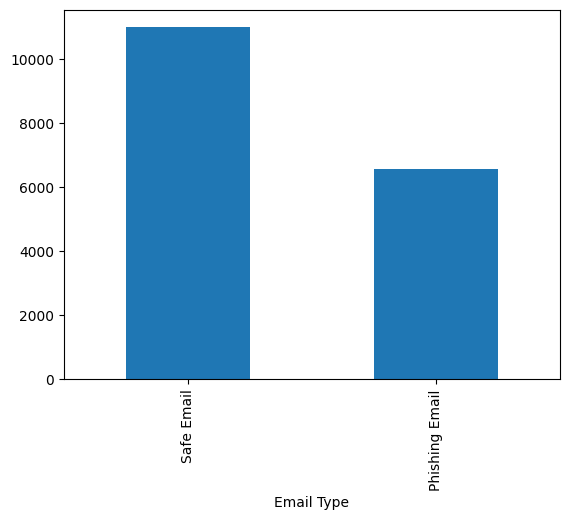

In [12]:
# Plot counts of Safe Email vs Phishing Email
df['Email Type'].value_counts().plot(kind='bar')

Now we need to further process and clean the data. This is a binary classification problem, and we need to assign a label (a 1 or a 0) to the email categories. Then we will remove URLS and non word characters from the emails - we are interested in the similarities of the text itself.  Then we lowercase all of the characters, convert all multiple whitespace characters to single whitespace, and remove any trailing whitespaces.

In [13]:
# Label Email Type
lbl = LabelEncoder()
df['Email Type'] = lbl.fit_transform(df['Email Type'])

In [14]:
# Function to preprocess text.
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Email Text']=df['Email Text'].apply(preprocess_text)

In [15]:
df.head(10)

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0
5,global risk management operations sally congra...,1
6,on sun aug 11 2002 at 111747am 0100 wintermute...,1
7,entourage stockmogul newsletter ralph velez ge...,0
8,we owe you lots of money dear applicant after ...,0
9,re coastal deal with exxon participation under...,1


## Simple Neural Network

The [`SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layer in TensorFlow is a [recurrent neural network (RNN)]9https://en.wikipedia.org/wiki/Recurrent_neural_network) layer that processes sequential data, making it suitable for tasks like time series prediction or text generation. Each unit in SimpleRNN maintains a hidden state across time steps, allowing the model to "remember" previous inputs in the sequence. It supports configurations for returning only the final output or the entire sequence, and can also be stacked with other layers for deeper architectures. This layer is simpler and faster than more complex RNN types, like LSTM or GRU, but may struggle with longer sequences.

Because our email messages are variable length, we need to fix the length of each vector we create. In deep learning, it’s often beneficial to have inputs of consistent shapes. Setting max_len ensures that all sequences are padded or truncated to a specific length, allowing you to batch-process sequences more efficiently. 


In [16]:
#Set max_len
max_len = 256

We initalize a new [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class which is used for preprocessing text data by converting words or characters into numerical representations that a machine learning model can understand. In general, a token is a word or a character.  In our case, a token is a word.

In [17]:
#Initialize new instance of Tokenizer class.
tk = Tokenizer()

The next step is to use `fit_on_texts` method in the 'Tokenizer' class to  processes each text entry in the `Email Text` column of the Pandas data frame to build a vocabulary, where each unique word (or token) is assigned a unique integer index based on its frequency across the entire dataset. It then creates a word index mapping each word (token) to a unique integer in each email. 

Then we use the `texts_to_sequences` method to create a list of integer sequence for each email from our word index mappings.  These sequence of integers are then converted to vectors of fixed length (256 from our max_len variable) and padded or truncated as necessary and stored in a numpy array.


In [18]:
# Process the text
tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [19]:
#Number of rows in the vector numpy array, matches the number of emails in our dataset.
vector.shape[0]

17538

In [20]:
#Length of our word index
len(tk.word_index) + 1

182317

Now we set the `max_features` parameter to limit our overall vocabulary size to the most frequent words. There are two main reasons for this:

- Reduces Memory Usage: In many NLP tasks, datasets contain thousands or millions of unique words. Limiting the vocabulary size to the most frequent words helps reduce memory and computational requirements, which is especially helpful when working with limited resources or large datasets.
- Improves Model Generalization: High vocabulary sizes can lead to overfitting, as the model might memorize rare words that do not generalize well to new data. Setting max_features forces the model to focus on the most important and commonly occurring words, which generally improves performance on unseen data

In [21]:
max_features=10000

Now we set up a two dimensional array of our vectors and the corresponding labels. 

In [22]:
# Is this chunk of code necessary?
#X = np.array(vector)
#y = np.array(df['Email Type'])

In [23]:
x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

In [24]:
model_srnn = Sequential() # Sequential() API
model_srnn.add(Embedding(len(tk.word_index)+1,50))
model_srnn.add(SimpleRNN(units=100))
model_srnn.add(Dropout(0.5))
model_srnn .add(Dense(1, activation='sigmoid'))

I0000 00:00:1731085150.776474   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085150.776573   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085150.776589   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085150.776715   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731085150.776731   27423 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [25]:
model_srnn.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [26]:
historical_srnn  = model_srnn.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20


I0000 00:00:1731085151.878344   27519 service.cc:146] XLA service 0x7fb81401a5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731085151.878378   27519 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-11-08 11:59:11.897702: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-08 11:59:11.994400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  5/877 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.6263 - loss: 0.6573

I0000 00:00:1731085152.545498   27519 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


877/877 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.5631 - loss: 0.7121 - val_accuracy: 0.6149 - val_loss: 0.6710
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.5966 - loss: 0.6811 - val_accuracy: 0.6300 - val_loss: 0.6533
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6377 - loss: 0.6424 - val_accuracy: 0.6582 - val_loss: 0.6241
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6769 - loss: 0.5956 - val_accuracy: 0.6673 - val_loss: 0.6092
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.6865 - loss: 0.5744 - val_accuracy: 0.6596 - val_loss: 0.6050
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.6929 - loss: 0.5526 - val_accuracy: 0.6568 - val_loss: 0.6344
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6949 - loss: 0.5467 - val_accuracy: 0.6733 - val_loss: 0.5968
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.7065 - loss: 0.5287 - val_accurac

Text(0, 0.5, 'Loss')

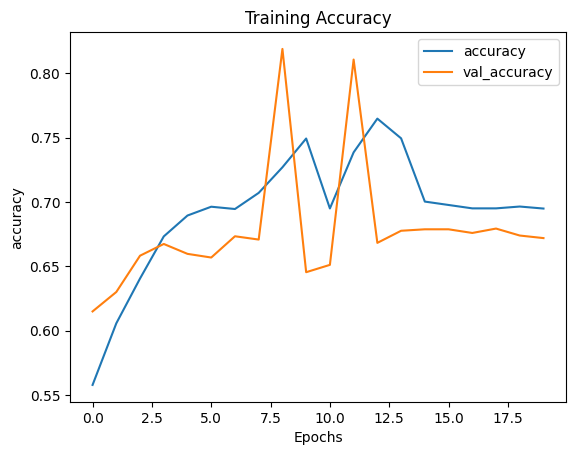

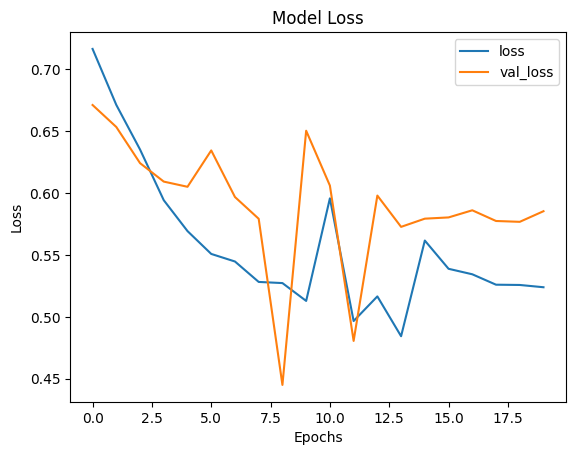

In [27]:

pd.DataFrame(historical_srnn.history)

pd.DataFrame(historical_srnn.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_srnn.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


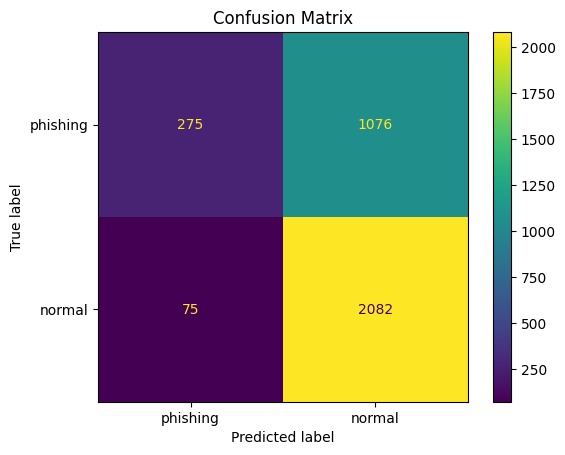

In [28]:
y_pred_prob_smp = model_srnn.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)


cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['phishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

In [29]:
# Evaluate the model on the test set
srnn_loss, srnn_accu = model_srnn.evaluate(x_test, y_test, verbose=0)

srnn_accu = (srnn_accu*100)

# Display the accuracy value
print(f'The accuracy of the SRNN model on the test data set was: {srnn_accu:.4f}')

The accuracy of the SRNN model on the test data set was: 67.1893


## LTSM

In [30]:
model_lstm = Sequential() # Sequential() API
model_lstm.add(Embedding(len(tk.word_index)+1,50))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

In [31]:
model_lstm.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [32]:
historical_lstm  = model_lstm.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6399 - loss: 0.6328 - val_accuracy: 0.8201 - val_loss: 0.4528
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7915 - loss: 0.4679 - val_accuracy: 0.6881 - val_loss: 0.5208
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8003 - loss: 0.4138 - val_accuracy: 0.9518 - val_loss: 0.1533
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9722 - loss: 0.1200 - val_accuracy: 0.9669 - val_loss: 0.1018
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9870 - loss: 0.0577 - val_accuracy: 0.9726 - val_loss: 0.0834
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9915 - loss: 0.0324 - val_accuracy: 0.9749 - val_loss: 0.1025
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9962 - loss: 0.0179 - val_accuracy: 0.9595 - val_loss: 0.1804
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9957 - loss: 0.0230 - 

In [33]:
lstm_results = model_lstm.evaluate(x_test, y_test)
lstm_loss = lstm_results[0]  # Extract the loss from the results
lstm_accu = (lstm_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {lstm_loss}")
print(f"Model Accuracy: {lstm_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9793 - loss: 0.1355
Model Loss: 0.14064064621925354
Model Accuracy: 97.89053797721863


In [34]:
y_pred_prob = model_lstm.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Text(0, 0.5, 'Loss')

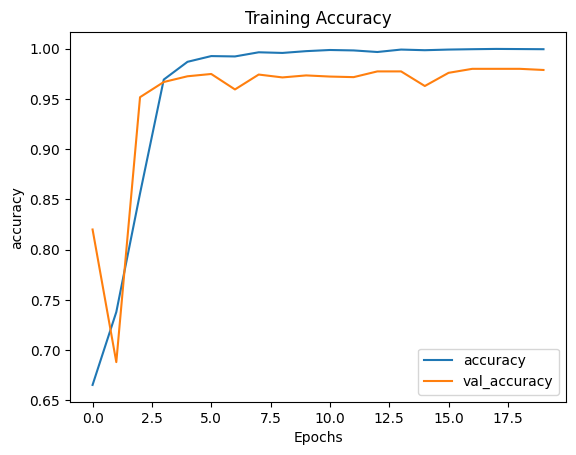

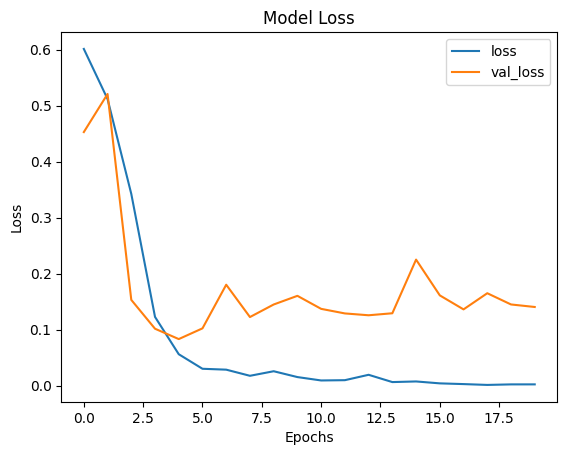

In [35]:
pd.DataFrame(historical_lstm.history)

pd.DataFrame(historical_lstm.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_lstm.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

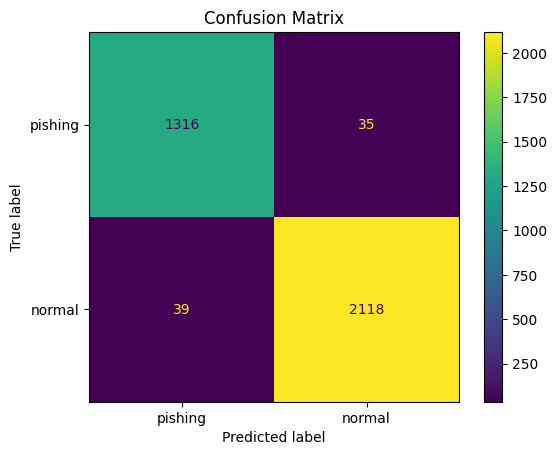

In [36]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['pishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

## Bidirectional

In [37]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(len(tk.word_index)+1,50))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [38]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [39]:
historical_bi  = model_bi.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.8154 - loss: 0.3912 - val_accuracy: 0.9723 - val_loss: 0.0871
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.9844 - loss: 0.0501 - val_accuracy: 0.9818 - val_loss: 0.0667
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9911 - loss: 0.0290 - val_accuracy: 0.9692 - val_loss: 0.0967
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.9948 - loss: 0.0187 - val_accuracy: 0.9666 - val_loss: 0.0989
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9956 - loss: 0.0188 - val_accuracy: 0.9729 - val_loss: 0.0993
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9969 - loss: 0.0128 - val_accuracy: 0.9752 - val_loss: 0.1040
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9769 - val_loss: 0.1145
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9996 - loss: 0.0018 - 

In [40]:
bi_results = model_bi.evaluate(x_test, y_test)
bi_loss = bi_results[0]  # Extract the loss from the results
bi_accu = (bi_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {bi_loss}")
print(f"Model Accuracy: {bi_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9771 - loss: 0.1613
Model Loss: 0.12064629793167114
Model Accuracy: 97.8050172328949


In [41]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Text(0, 0.5, 'Loss')

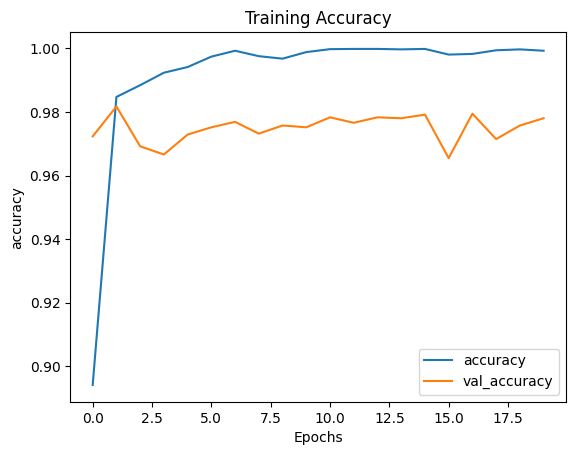

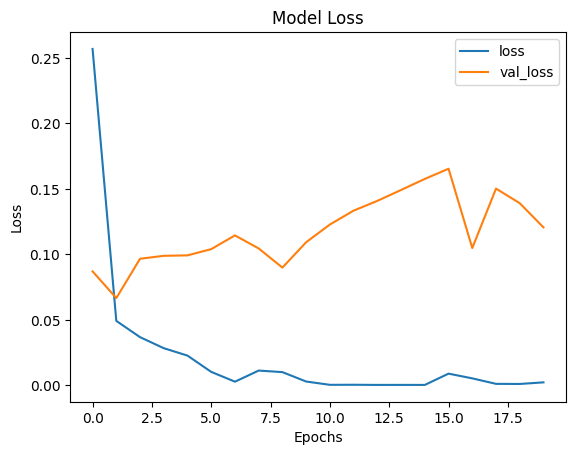

In [42]:
pd.DataFrame(historical_bi.history)

pd.DataFrame(historical_bi.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_bi.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

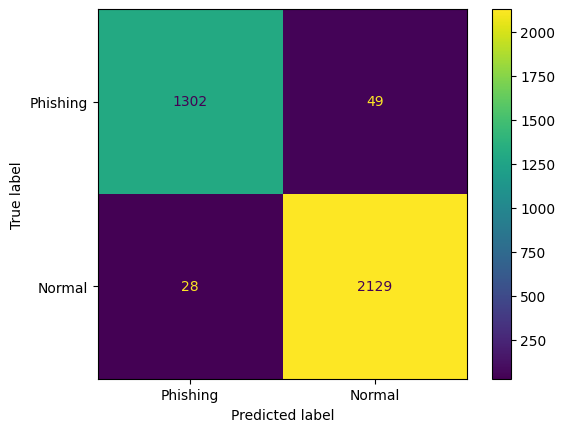

In [43]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Phishing','Normal'])
ax_bi.plot()
plt.show()

### Gated Recurrent Unit

In [44]:
model_gru = Sequential() # Sequential() API
model_gru.add(Embedding(len(tk.word_index)+1,50))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

In [45]:
model_gru.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [46]:
historical_gru = model_gru.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.6346 - loss: 0.6468 - val_accuracy: 0.9458 - val_loss: 0.1803
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9549 - loss: 0.1405 - val_accuracy: 0.9743 - val_loss: 0.0743
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9929 - loss: 0.0261 - val_accuracy: 0.9761 - val_loss: 0.0731
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9967 - loss: 0.0127 - val_accuracy: 0.9815 - val_loss: 0.0682
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9988 - loss: 0.0044 - val_accuracy: 0.9820 - val_loss: 0.0972
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9826 - val_loss: 0.0782
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9832 - val_loss: 0.0658
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9996 - loss: 0.0017 - 

In [47]:
gru_results = model_gru.evaluate(x_test, y_test)
gru_loss = gru_results[0]  # Extract the loss from the results
gru_accu = (gru_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {gru_loss}")
print(f"Model Accuracy: {gru_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9828 - loss: 0.1376
Model Loss: 0.11717180907726288
Model Accuracy: 98.3466386795044


In [48]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Text(0, 0.5, 'Loss')

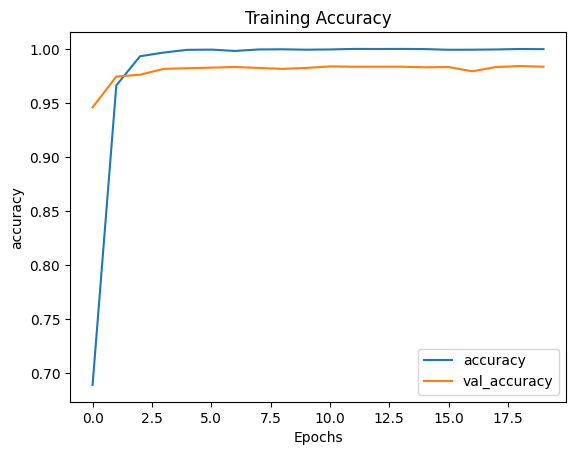

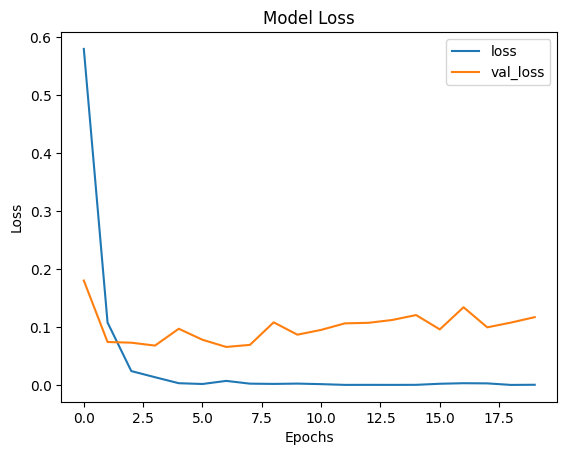

In [49]:
pd.DataFrame(historical_gru.history)

pd.DataFrame(historical_gru.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_gru.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

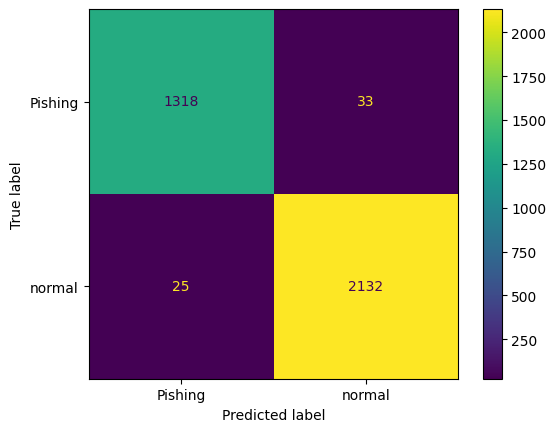

In [50]:
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(confusion_matrix=cnf_gru,display_labels=['Pishing','normal'])
ax_gru.plot()
plt.show()

# Model Comparisons

In [51]:
# Need to do - set up table of models and comparisons

accu_values = [srnn_accu,lstm_accu, bi_accu, gru_accu]
row_labels = ["Simple RNN", "LSTM Neural Network", "Bidirectional Neural Network", "Gated Recurrent Unit"]
comp_df = pd.DataFrame(accu_values, columns=["accuracy"], index=row_labels)
print(comp_df)

                               accuracy
Simple RNN                    67.189282
LSTM Neural Network           97.890538
Bidirectional Neural Network  97.805017
Gated Recurrent Unit          98.346639
